Dataset loaded successfully.

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None

Missing values before filling:
Sulfate            781
ph                 491
Trihalomethanes    162
Hardness             0
Solids               0
Chloramines          0
Conductivity         0
Organic_carbon       0
Turbidity            0
P

C:\Users\daven\AppData\Local\Temp\ipykernel_31572\119181523.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Potability', palette='viridis')


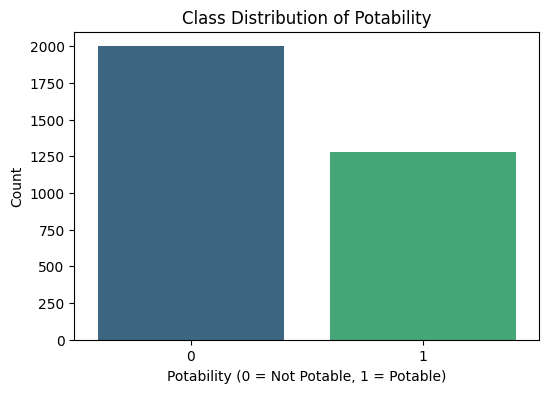


Class distribution after SMOTE:
0    1998
1    1998
Name: Potability, dtype: int64

Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': None}

Tuning hyperparameters for Gradient Boosting...
Best parameters for Gradient Boosting: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}

Tuning hyperparameters for XGBoost...


c:\Users\daven\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:29:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\daven\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for XGBoost: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}

Tuning hyperparameters for SVM...
Best parameters for SVM: {'kernel': 'rbf', 'C': 10}

Summary of Model Performance:
               Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0      Random Forest    0.6925     0.6915  0.6950    0.6933   0.7663
1  Gradient Boosting    0.6775     0.6868  0.6525    0.6692   0.7525
2            XGBoost    0.6838     0.6754  0.7075    0.6911   0.7519
3                SVM    0.6425     0.6319  0.6825    0.6562   0.7038


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)

# Load dataset
url = 'water_potability.csv'
try:
    df = pd.read_csv(url)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'water_potability.csv' was not found.")
    raise

# Inspect dataset
print("\nDataset info:")
print(df.info())

# Clean column names (remove leading/trailing spaces)
df.columns = df.columns.str.strip()

# Check for missing values
print("\nMissing values before filling:")
print(df.isnull().sum().sort_values(ascending=False))

# Fill missing values
df['Sulfate'] = df['Sulfate'].fillna(df['Sulfate'].mode()[0])  # Fill with mode
df['ph'] = df['ph'].fillna(df['ph'].mean())                  # Fill with mean
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df['Trihalomethanes'].mode()[0])

# Check class distribution
print("\nClass distribution in 'Potability':")
print(df['Potability'].value_counts())

# Visualize class imbalance
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Potability', palette='viridis')
plt.title('Class Distribution of Potability')
plt.xlabel('Potability (0 = Not Potable, 1 = Potable)')
plt.ylabel('Count')
plt.show()

# Feature-target separation
features = df.drop('Potability', axis=1)
target = df['Potability']

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
features_resampled, target_resampled = smote.fit_resample(features, target)
print("\nClass distribution after SMOTE:")
print(pd.Series(target_resampled).value_counts())

# Split dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(
    features_resampled, target_resampled, test_size=0.2, random_state=42, stratify=target_resampled
)

# Scale features
scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Models and hyperparameters
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42)
}

# Hyperparameter grids
param_grids = {
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    "Gradient Boosting": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
    }
}

results_list = []

# Train and evaluate each model with hyperparameter tuning
for name, model in models.items():
    print(f"\nTuning hyperparameters for {name}...")
    param_grid = param_grids[name]
    grid_search = RandomizedSearchCV(
        model, param_grid, n_iter=10, cv=3, scoring='accuracy', random_state=42, n_jobs=-1
    )
    grid_search.fit(x_train_scaled, y_train)

    # Best model
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

    # Evaluate best model
    y_pred = best_model.predict(x_test_scaled)
    y_pred_prob = best_model.predict_proba(x_test_scaled)[:, 1] if hasattr(best_model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else 0.5

    results_list.append({
        "Model": name,
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
    })

# Convert results to DataFrame and display
summary = pd.DataFrame(results_list)
print("\nSummary of Model Performance:")
print(summary)

In [3]:
import pickle

# Save the best model
model_filename = 'random_forest_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model saved to {model_filename}.")

Model saved to random_forest_model.pkl.
